# Fallback Table Metalearning ANALYSIS


In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')



Attaching package: ‘tidyr’


The following object is masked from ‘package:stringdist’:

    extract




In [5]:
source('functions_metalearning.R')

In [6]:
source('functions_fallback.R')

In [7]:
# source('load_prep_data_expiry_2.R') #read in train test and predictions manually instead

# READ CSV's
# expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")
# expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
# expiry_df_test <- read.csv("../../data/output/datapull_20201116/expiry_df_test.csv")
# metametrics_df <- read.csv("../../data/output/datapull_20201116/expiry_metametrics_df.csv")
# expiry_df
# expiry_train_df 
# expiry_test_df 
# expiry_list
# expiry_train_list
# expiry_test_list

In [8]:
dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116'

modelDir='/home/jupyter/Domains_202003/data/output/models_20201104'

outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'

# Load predictions on new datapull

In [12]:
# expiry_new_df <- readRDS(file.path(outputDir,"expiry_20200902_20201102_20201127"))
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")

expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))
expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

dim(expiry_new_df)
head(expiry_new_df)

Expiry data originally has 476586 rows and 476586 missing geo's.
... after intial merge on reseller & _country, expiry has 476586 rows and 476408 missing geo's.
... after secondary fill with _country, expiry has 476586 rows and 496 missing geo's.
... after manual tweaks with _country, expiry has 476586 rows and 71 missing geo's.


[1] 476586     33

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU


In [9]:
meta_preds <- read.csv(file.path(outputDir, 'meta_preds', 'meta_preds.csv'))
dim(meta_preds)
head(meta_preds)

[1] 535698     37

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


# Verify data integrity

In [15]:
meta_preds %>% group_by(tld_registrar_index) %>% tally() %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<fct>,<int>
funalibaba,53324
spacealibaba,38716
sitegmo,34803
websitealibaba,25010
sitenamecheap,20337
sitereg.ru,13284


In [16]:
expiry_new_df %>% group_by(tld_registrar_index) %>% tally() %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<chr>,<int>
funalibaba,53324
sitegmo,34803
sitenamecheap,20337
spacealibaba,19358
sitereg.ru,13284
onlinego daddy,12936


# Evaluate perfromance

In [17]:
fallback_lift <- chart_lift(pred_df=meta_preds,
                        dep_var = "renewal_status",
                        pred_var = "predicted") 

fallback_lift
calc_auc(lift_df=fallback_lift)

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,15926,0.3611502,3.611502
0.2,26312,0.5966711,2.983355
0.3,34056,0.7722799,2.574266
0.4,38378,0.8702889,2.175722
0.5,41118,0.9324232,1.864846
0.6,42562,0.9651685,1.608614
0.7,43121,0.9778448,1.396921
0.8,43349,0.9830151,1.228769
0.9,43517,0.9868248,1.096472


[1] 0.7945666

In [18]:
prop.table(table(meta_preds$renewal_status))


Not Renewd    Renewed 
0.91768123 0.08231877 

In [19]:
plot_multigains <- function (lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


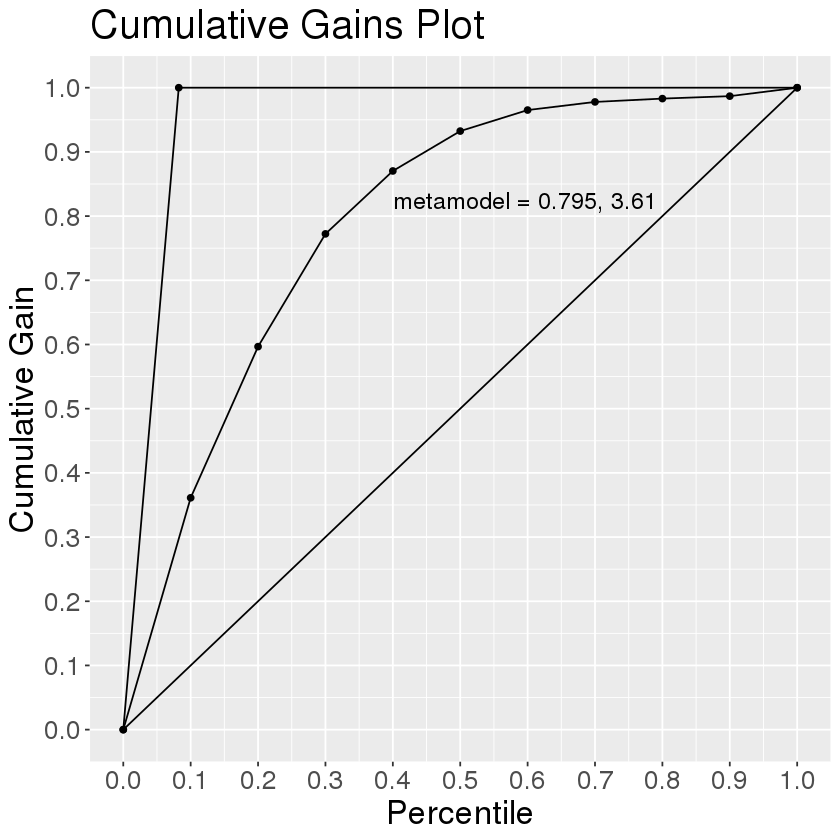

In [21]:
plot_multigains(lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) 

# FUP for Parag: 
## tabular (& visual) representation -- which registrars, which model (reseller priority level) 
## also performance metrics, see below (but that may be for the following Th)

### 1. Tabular

In [22]:
names(meta_preds)
head(meta_preds)

[1] "X"                    "reseller"             "reseller_country"    
 [4] "renewal_type"         "renewed_count"        "expiry_date"         
 [7] "creation_date"        "status"               "domain_id"           
[10] "domain"               "registrar"            "registrant_country"  
[13] "reg_period"           "reg_revenue"          "reg_arpt"            
[16] "renew_mbg"            "renewal_item_id"      "renew_type"          
[19] "autorenew_type"       "renewal_status"       "renew_date"          
[22] "renew_arpt"           "gibb_score"           "pattern"             
[25] "pattern_domain_count" "day_domains"          "sld_length"          
[28] "sld_type"             "sld_type2"            "tld"                 
[31] "region"               "log_reg_arpt"         "tld_registrar_index" 
[34] "reseller_geo"         "actual"               "predicted"           
[37] "model"

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [23]:
# add resellerand tld columns to metalearning predictions
# expiry_test_lookup <- expiry_df_test_preds %>% select(tld_registrar_index,reseller, tld) %>% distinct()
# vis_df <- merge(expiry_test_lookup,
#                 test_pred, by="tld_registrar_index", all.y=TRUE) 
# vis_df <- vis_df%>% rename_at(ncol(.), ~"l10_win_04_pred_model")
# vis_df <- vis_df%>% rename_at(ncol(.)-1, ~"auc_win_04_pred_model")
vis_df <- meta_preds
# add reseller priority columns to metalearning predictions
priorityLookup_df <- read.csv("/home/jupyter/Domains_202003/data/data_input/PredictiveModelAnalysis_ResellerPriorityList.csv")
names(priorityLookup_df) <- c("market","reseller","npv2020","priority")
priorityLookup_df$reseller <- tolower(priorityLookup_df$reseller)
vis_df$reseller <- tolower(vis_df$reseller)
vis_df <- merge(vis_df, priorityLookup_df, by="reseller", all.x=TRUE)



dim(vis_df)
head(vis_df)

[1] 535698     40

,reseller,X,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model,market,npv2020,priority
,<chr>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>
1,1&1 internet,73133,Germany,Subsequent,3,2020-10-02,2017-10-02,Active,53343383,genomission.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,8.58,genomission,2,77,11,l,11l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.7603850,preds_agg_rf_ALL,Europe,770943,1
2,1&1 internet,71319,Germany,Second,2,2020-09-12,2018-09-12,Active,76459334,revaaa.online,1&1 Internet,NA,1,25.0,25.0,0,336283329,renewal,NA,Renewed,2020-08-10,25,0.65,reaae,2,324,6,l,6l,online,Non China,3.2188758,online1&1 internet,EU,Renewed,0.6455068,preds_agg_rf_ALL,Europe,770943,1
3,1&1 internet,74160,Germany,FirstTime,1,2020-09-10,2019-09-10,Active,127850776,lickpussy.online,1&1 Internet,NA,1,0.6,0.6,0,345122893,auto-renewal,unrealized,Not Renewd,2020-09-10,25,2.65,lickpussy,1,75,9,l,9l,online,Non China,-0.5108256,online1&1 internet,EU,Not Renewd,0.5246619,preds_agg_rf_ALL,Europe,770943,1
4,1&1 internet,73152,Germany,Second,2,2020-09-20,2018-09-20,Active,76998309,graffitifresser.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,7.21,iegraffitifresser,2,125,15,l,15l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.5811250,preds_agg_rf_ALL,Europe,770943,1
5,1&1 internet,74180,Germany,FirstTime,1,2020-09-11,2019-09-11,Active,128299636,mensajes.online,1&1 Internet,NA,1,5.0,5.0,0,345442173,auto-renewal,realized,Renewed,2020-09-11,25,4.97,mensajes,1,91,8,l,8l,online,Non China,1.6094379,online1&1 internet,EU,Renewed,0.4517150,preds_agg_rf_ALL,Europe,770943,1
6,1&1 internet,73155,Germany,Second,2,2020-10-05,2018-10-05,Active,78370179,georgeshuot.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,3.03,georgeshuot,1,64,11,l,11l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.7859175,preds_agg_rf_ALL,Europe,770943,1


In [26]:
# by tld-reseller
vis_df_01 <- vis_df %>% select(tld_registrar_index, model) %>% distinct()
dim(vis_df_01)
head(vis_df_01)

[1] 2049    2

,tld_registrar_index,model
,<fct>,<fct>
1,online1&1 internet,preds_agg_rf_ALL
2,site1&1 internet,preds_agg_rf_ALL
3,fun1&1 internet,preds_seg2_glm_ALL
4,tech1&1 internet,preds_agg_rf_ALL
5,space1&1 internet,preds_agg_rf_ALL
6,store1&1 internet,preds_agg_rf_ALL


In [27]:
write.csv(vis_df_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytldre.csv', row.names=FALSE)

In [29]:
# by reseller
vis_df_02 <- vis_df %>% select(reseller, model) %>% distinct()
vis_df_02_01 <- vis_df_02 %>%
  group_by(reseller, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_02_01)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,model,n,freq
<chr>,<fct>,<int>,<dbl>
1&1 internet,preds_agg_rf_ALL,1,0.50
1&1 internet,preds_seg2_glm_ALL,1,0.50
101 domain,preds_agg_rf_ALL,1,0.33
101 domain,preds_seg2_glm_ALL,1,0.33
101 domain,preds_seg2_glm_fb,1,0.33
10dencehispahard,preds_agg_rf_ALL,1,0.50


In [30]:
write.csv(vis_df_02_01, '../../data/output/deliv_20201210/20200902_20201008_model_byre_auc.csv', row.names=FALSE)

In [31]:
vis_df_02_02 <- vis_df_02 %>%
  group_by(reseller, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_02_02)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,model,n,freq
<chr>,<fct>,<int>,<dbl>
1&1 internet,preds_agg_rf_ALL,1,0.50
1&1 internet,preds_seg2_glm_ALL,1,0.50
101 domain,preds_agg_rf_ALL,1,0.33
101 domain,preds_seg2_glm_ALL,1,0.33
101 domain,preds_seg2_glm_fb,1,0.33
10dencehispahard,preds_agg_rf_ALL,1,0.50


In [32]:
write.csv(vis_df_02_02, '../../data/output/deliv_20201210/20200902_20201008_model_byre_l10.csv', row.names=FALSE)

In [34]:
# by tld
vis_df_03 <- vis_df %>% select(tld,model) 
vis_df_03_01 <- vis_df_03 %>%
  group_by(tld, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_03_01)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)



tld,model,n,freq
<fct>,<fct>,<int>,<dbl>
fun,preds_agg_rf_ALL,64057,0.95
fun,preds_seg2_glm_ALL,2994,0.04
fun,preds_seg2_glm_fb,382,0.01
host,preds_agg_rf_ALL,6851,0.88
host,preds_seg2_glm_ALL,864,0.11
host,preds_seg2_glm_fb,49,0.01


In [35]:
write.csv(vis_df_03_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytld_auc.csv', row.names=FALSE)

In [37]:
# by priority
vis_df_04 <- vis_df %>% select(priority, model)
vis_df_04_01 <- vis_df_04 %>%
  group_by(priority, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_04_01)

`summarise()` regrouping output by 'priority' (override with `.groups` argument)



priority,model,n,freq
<int>,<fct>,<int>,<dbl>
1,preds_agg_rf_ALL,349120,0.89
1,preds_seg2_glm_ALL,41102,0.11
1,preds_seg2_glm_fb,529,0.00
2,preds_agg_rf_ALL,43702,0.87
2,preds_seg2_glm_ALL,5609,0.11
2,preds_seg2_glm_fb,661,0.01


In [38]:
write.csv(vis_df_04_01, '../../data/output/deliv_20201210/20200902_20201008_model_bypri_auc.csv', row.names=FALSE)

In [76]:
# cross section graph of tld vs reseller and model (w/ shading) in the intersection: 
#    https://www.r-graph-gallery.com/79-levelplot-with-ggplot2.html
# by reseller:  percentage of each model assigned
# by tld:  percentage of each model assigned
# by priority: percentage of each model assigned

In [64]:
head(test_pred)

,tld_registrar_index,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,⋯,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,pred_l10$l10_win_04_pred_model,pred_auc$auc_win_04_pred_model
,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
3,fun1api,EU,1,8,0.50000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.1564401,4,15,8.875000,11,3.5228844,0.4848693,-1.143452,2.00,6.09,4.396250,4.09,⋯,0.4250000,0.3500000,0.4750000,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm
7,funalibaba sg,China,1,195,0.04102564,1,0.005128205,1,490,296.728205,489,228.3117623,-0.3415584,-1.8644672,4,15,6.794872,11,2.3106598,1.4636429,1.315210,0.12,16.72,4.425128,16.60,⋯,0.8625000,0.8875000,0.8750000,0.8750000,0.8750000,7.500000,5.000000,6.250000,6.250000,3.750000,2.500000,3.750000,3.750000,0.9250000,0.9000000,0.8625000,0.8500000,0.8875000,0.8750000,0.8750000,0.8750000,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL
15,funcafe24,"Vietnam, Korea & Indonesia",1,3,0.00000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,5,6,5.666667,1,0.5773503,-0.3849002,-2.333333,0.48,5.80,2.926667,5.32,⋯,0.6000376,0.6546695,0.6871427,0.6360214,0.5983887,4.269437,4.363352,4.031874,4.008743,4.829749,4.852859,4.669066,4.758851,0.6076759,0.6139171,0.6158047,0.5954856,0.6227286,0.6291192,0.6194290,0.6157651,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
21,funcronon ag,EU,1,10,0.70000000,1,0.100000000,1,3,1.400000,2,0.6992059,1.1935618,-0.0746281,3,24,11.400000,21,7.3966960,0.7355118,-1.053701,1.05,100.00,13.731000,98.95,⋯,0.6500000,0.6500000,0.6500000,0.6500000,0.5785714,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL
22,funcsc corporate,United States,1,3,1.00000000,1,0.333333333,1,4,3.000000,3,1.7320508,-0.3849002,-2.3333333,11,16,14.000000,5,2.6457513,-0.3239695,-2.333333,4.71,6.28,5.233333,1.57,⋯,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
43,funglobal domains,United States,1,271,0.00000000,1,0.003690037,1,71,32.129151,70,20.7593334,0.4921998,-0.8367946,4,23,11.025830,19,3.6223684,1.0939010,1.296427,0.52,12.22,5.511661,11.70,⋯,0.6808176,0.8503536,0.8506547,0.8514446,0.8429044,4.789892,4.669712,3.382280,3.507468,5.424845,5.820438,5.325877,5.228621,0.7781662,0.7643041,0.6961987,0.7015210,0.8323627,0.8491662,0.8370442,0.8319197,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL


In [65]:
vis_df <- merge(expiry_df_test_preds %>% select(tld_registrar_index,reseller, tld) %>% distinct(),
                test_pred, by="tld_registrar_index", all.y=TRUE) 
dim(vis_df)
names(vis_df)
head(vis_df)

[1] 360  84

[1] "tld_registrar_index"   "reseller"              "tld"                  
 [4] "geo_maj"               "geo_cnt"               "n"                    
 [7] "ren_prp"               "tld_cnt"               "tld_rat"              
[10] "daydom_min"            "daydom_max"            "daydom_mean"          
[13] "daydom_rng"            "daydom_std"            "daydom_skew"          
[16] "daydom_kurt"           "sldlen_min"            "sldlen_max"           
[19] "sldlen_mean"           "sldlen_rng"            "sldlen_std"           
[22] "sldlen_skew"           "sldlen_kurt"           "gibbs_min"            
[25] "gibbs_max"             "gibbs_mean"            "gibbs_rng"            
[28] "gibbs_std"             "gibbs_skew"            "gibbs_kurt"           
[31] "pdcnt_min"             "pdcnt_max"             "pdcnt_mean"           
[34] "pdcnt_rng"             "pdcnt_std"             "pdcnt_skew"           
[37] "pdcnt_kurt"            "regarpt_min"           "regarpt_max"          
[40] "regarpt_mean"          "regarpt_rng"           "regarpt_std"          
[43] "regarpt_skew"          "regarpt_kurt"          "country_maj"          
[46] "region_maj"            "country_cnt"           "region_cnt"           
[49] "l10_seg2_glm"          "l10_seg_glm"           "l10_agg_glm_ALL"      
[52] "l10_agg_glm"           "l10_seg2_rf"           "l10_seg_rf"           
[55] "l10_agg_rf"            "l10_agg_rf_ALL"        "auc_seg2_glm"         
[58] "auc_seg_glm"           "auc_agg_glm_ALL"       "auc_agg_glm"          
[61] "auc_seg2_rf"           "auc_seg_rf"            "auc_agg_rf_ALL"       
[64] "auc_agg_rf"            "l10_seg2_glm_fb"       "l10_seg_glm_fb"       
[67] "l10_agg_glm_fb"        "l10_agg_glm_ALL_fb"    "l10_seg2_rf_fb"       
[70] "l10_seg_rf_fb"         "l10_agg_rf_fb"         "l10_agg_rf_ALL_fb"    
[73] "auc_seg2_glm_fb"       "auc_seg_glm_fb"        "auc_agg_glm_fb"       
[76] "auc_agg_glm_ALL_fb"    "auc_seg2_rf_fb"        "auc_seg_rf_fb"        
[79] "auc_agg_rf_fb"         "auc_agg_rf_ALL_fb"     "auc_win_04"           
[82] "l10_win_04"            "auc_win_04_pred_model" "l10_win_04_pred_model"

,tld_registrar_index,reseller,tld,geo_maj,geo_cnt,n,ren_prp,tld_cnt,tld_rat,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,⋯,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf_ALL,auc_agg_rf,l10_seg2_glm_fb,l10_seg_glm_fb,l10_agg_glm_fb,l10_agg_glm_ALL_fb,l10_seg2_rf_fb,l10_seg_rf_fb,l10_agg_rf_fb,l10_agg_rf_ALL_fb,auc_seg2_glm_fb,auc_seg_glm_fb,auc_agg_glm_fb,auc_agg_glm_ALL_fb,auc_seg2_rf_fb,auc_seg_rf_fb,auc_agg_rf_fb,auc_agg_rf_ALL_fb,auc_win_04,l10_win_04,auc_win_04_pred_model,l10_win_04_pred_model
,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
1,fun1api,1API,fun,EU,1,8,0.50000000,1,0.125000000,1,1,1.000000,0,0.0000000,1.5658080,1.1564401,4,15,8.875000,11,3.5228844,0.4848693,-1.143452,2.00,6.09,⋯,0.4250000,0.3500000,0.4750000,0.3500000,0.5500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,0.4250000,auc_seg2_glm_fb,l10_seg2_glm_fb,l10_seg2_glm,auc_seg2_glm
2,funalibaba sg,Alibaba SG,fun,China,1,195,0.04102564,1,0.005128205,1,490,296.728205,489,228.3117623,-0.3415584,-1.8644672,4,15,6.794872,11,2.3106598,1.4636429,1.315210,0.12,16.72,⋯,0.8625000,0.8875000,0.8750000,0.8750000,0.8750000,7.500000,5.000000,6.250000,6.250000,3.750000,2.500000,3.750000,3.750000,0.9250000,0.9000000,0.8625000,0.8500000,0.8875000,0.8750000,0.8750000,0.8750000,auc_seg2_glm,l10_seg2_glm,l10_agg_rf_ALL,auc_agg_rf_ALL
3,funcafe24,Cafe24,fun,"Vietnam, Korea & Indonesia",1,3,0.00000000,1,0.333333333,1,2,1.333333,1,0.5773503,0.3849002,-2.3333333,5,6,5.666667,1,0.5773503,-0.3849002,-2.333333,0.48,5.80,⋯,0.6000376,0.6546695,0.6871427,0.6360214,0.5983887,4.269437,4.363352,4.031874,4.008743,4.829749,4.852859,4.669066,4.758851,0.6076759,0.6139171,0.6158047,0.5954856,0.6227286,0.6291192,0.6194290,0.6157651,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
4,funcronon ag,Cronon AG,fun,EU,1,10,0.70000000,1,0.100000000,1,3,1.400000,2,0.6992059,1.1935618,-0.0746281,3,24,11.400000,21,7.3966960,0.7355118,-1.053701,1.05,100.00,⋯,0.6500000,0.6500000,0.6500000,0.6500000,0.5785714,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,0.5071429,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_agg_rf_ALL
5,funcsc corporate,CSC Corporate,fun,United States,1,3,1.00000000,1,0.333333333,1,4,3.000000,3,1.7320508,-0.3849002,-2.3333333,11,16,14.000000,5,2.6457513,-0.3239695,-2.333333,4.71,6.28,⋯,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,3.333333,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,0.5500000,auc_seg2_glm,l10_seg2_glm,l10_seg2_glm,auc_seg2_glm
6,funglobal domains,Global Domains,fun,United States,1,271,0.00000000,1,0.003690037,1,71,32.129151,70,20.7593334,0.4921998,-0.8367946,4,23,11.025830,19,3.6223684,1.0939010,1.296427,0.52,12.22,⋯,0.6808176,0.8503536,0.8506547,0.8514446,0.8429044,4.789892,4.669712,3.382280,3.507468,5.424845,5.820438,5.325877,5.228621,0.7781662,0.7643041,0.6961987,0.7015210,0.8323627,0.8491662,0.8370442,0.8319197,auc_agg_rf_ALL,l10_agg_rf_ALL,l10_agg_rf_ALL,auc_agg_rf_ALL


In [44]:
vis_sub <- vis_df %>% group_by(tld, reseller, model) %>% tally()
head(vis_sub)

tld,reseller,model,n
<fct>,<chr>,<fct>,<int>
fun,1&1 internet,preds_seg2_glm_ALL,18
fun,101 domain,preds_seg2_glm_ALL,1
fun,10dencehispahard,preds_seg2_glm_ALL,3
fun,1api,preds_agg_rf_ALL,2
fun,1api,preds_seg2_glm_ALL,2
fun,ab name isp,preds_seg2_glm_ALL,3


ERROR: Error:   Dimensions exceed 50 inches (height and width are specified in 'in' not pixels).
  If you're sure you want a plot that big, use `limitsize = FALSE`.


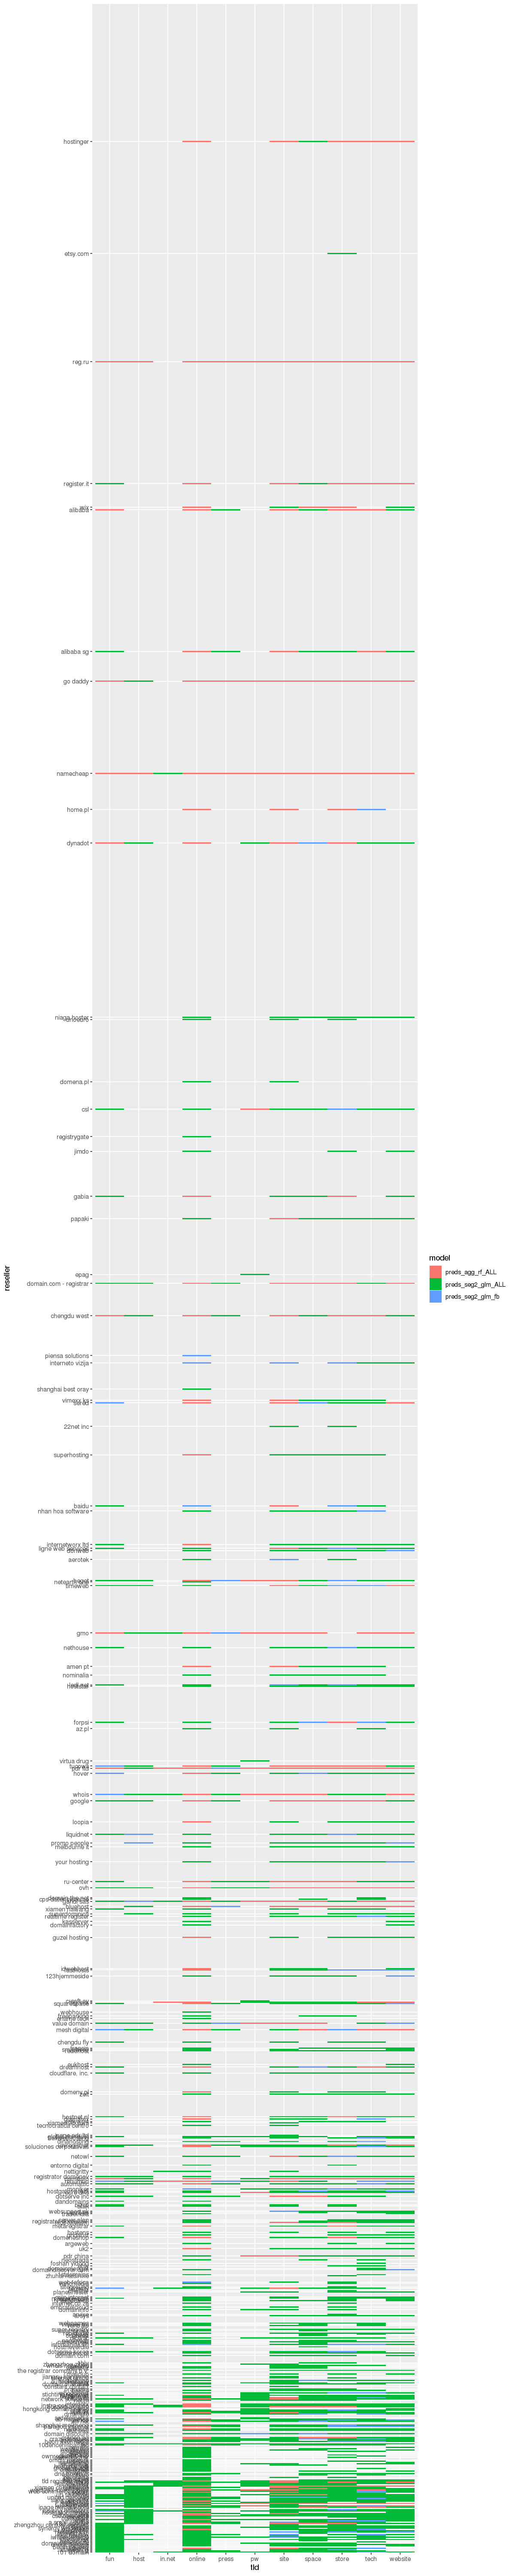

In [48]:
library(repr)
options(repr.plot.width=10, repr.plot.height=50)
ggplot(vis_sub , 
       aes(tld, reseller, fill=model)) + 
  geom_tile() + 
  scale_y_discrete(limits=(vis_sub$reseller)[order(vis_sub$n)])
ggsave('../../data/output/deliv_20201210/20200902_20201008_plot.pdf', width=10, height= 50) #A4 size in inches

In [54]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")

# FUP for Parag: 
## table of predictions at domain level based on model assignment

In [38]:
head(expiry_df_test_preds_assign)

,tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.4780584,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584
2,fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,NA,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA
3,fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.6194136,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136
4,fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.4426250,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250
5,fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.7268515,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515
6,fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.7021113,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113


In [39]:
names(expiry_df_test_preds_assign)

[1] "tld_registrar_index"   "reseller"              "reseller_country"     
 [4] "domain_id"             "renewal_type"          "renewed_count"        
 [7] "expiry_date"           "creation_date"         "status"               
[10] "domain"                "registrar"             "registrant_country"   
[13] "reg_period"            "reg_revenue"           "reg_arpt"             
[16] "renew_mbg"             "renewal_item_id"       "renew_type"           
[19] "autorenew_type"        "renewal_status"        "renew_date"           
[22] "renew_arpt"            "gibb_score"            "pattern"              
[25] "pattern_domain_count"  "day_domains"           "sld_length"           
[28] "sld_type"              "sld_type2"             "tld"                  
[31] "region"                "log_reg_arpt"          "pred_agg_glm_ALL"     
[34] "pred_agg_rf_ALL"       "pred_agg_glm"          "pred_agg_rf"          
[37] "pred_seg_glm_ALL"      "pred_seg_rf_ALL"       "pred_seg2_glm_ALL"    
[40] "pred_seg2_rf_ALL"      "reseller_geo"          "pred_agg_glm_ALL_fb"  
[43] "pred_agg_rf_ALL_fb"    "pred_agg_glm_fb"       "pred_agg_rf_fb"       
[46] "pred_seg_glm_ALL_fb"   "pred_seg_rf_ALL_fb"    "pred_seg2_glm_ALL_fb" 
[49] "pred_seg2_rf_ALL_fb"   "reg_arpt_org"          "reg_arpt_slab"        
[52] "pred_seg2_rf_ALL_fb2"  "pred_seg2_glm_ALL_fb2" "pred_seg_rf_ALL_fb2"  
[55] "pred_seg_glm_ALL_fb2"  "pred_agg_rf_fb2"       "pred_agg_glm_fb2"     
[58] "pred_agg_rf_ALL_fb2"   "pred_agg_glm_ALL_fb2"  "l10_win_04_pred_model"
[61] "auc_win_04_pred_model" "l10_win_04_pred_value" "auc_win_04_pred_value"

In [70]:
expiry_df_test_preds_assign %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                       'l10_win_04_pred_model','auc_win_04_pred_model',
                                       'l10_win_04_pred_value','auc_win_04_pred_value') %>% head()

,tld_registrar_index,reseller,tld,domain_id,domain,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,fun1api,1API,fun,77112544,alparty.fun,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584
2,fun1api,1API,fun,118771316,echt-geil.fun,l10_seg2_glm,auc_seg2_glm,NA,NA
3,fun1api,1API,fun,101717674,gotsome.fun,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136
4,fun1api,1API,fun,89153032,noor.fun,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250
5,fun1api,1API,fun,118627451,laurendoesstuff.fun,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515
6,fun1api,1API,fun,93057463,bottegaveneta.fun,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113


In [72]:
prop.table(table(expiry_df_test_preds_assign$l10_win_04_pred_model))
prop.table(table(expiry_df_test_preds_assign$auc_win_04_pred_model))


 l10_agg_rf_ALL    l10_seg2_glm l10_seg2_glm_fb 
   0.9268150060    0.0727413875    0.0004436065 


 auc_agg_rf_ALL    auc_seg2_glm auc_seg2_glm_fb 
    0.935626645     0.062256142     0.002117213 

In [73]:
dim(expiry_df_test_preds_assign)

[1] 99187    63

In [75]:
write.csv(expiry_df_test_preds_assign %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                       'l10_win_04_pred_model','auc_win_04_pred_model',
                                       'l10_win_04_pred_value','auc_win_04_pred_value') ,
         '../../data/output/deliv_20201203/20190601_20200901_preds.csv', row.names=FALSE)

system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")

## Aside: confirm that seg2_glm prediction for domain_id='118771316' is NA ***DONE!!***

In [43]:
expiry_df_test_preds_assign %>% filter (domain_id == 118771316) %>% t()

tld_registrar_index,fun1api
reseller,1API
reseller_country,Germany
domain_id,118771316
renewal_type,FirstTime
renewed_count,1
expiry_date,2020-08-20
creation_date,2019-08-20
status,Active
domain,echt-geil.fun
registrar,1API


In [45]:
tld_reseller_str = expiry_df_test_preds_assign %>% filter (domain_id == 118771316) %>% pull(tld_registrar_index)
tld_reseller_str

[1] fun1api
1758 Levels: fun1&1 internet fun10dencehispahard fun1api ... websitezhengzhou century connect

In [50]:
model_name <- paste0('model_seg2_glm_',str_replace_all(tld_reseller_str, "[^[:alnum:]]", ""))
paste0(model_name,'.Rdata')

[1] "model_seg2_glm_fun1api.Rdata"

In [53]:
modelDir='../../data/output/models_20201104'

In [54]:
load(file.path(modelDir, paste0(model_name,'.RData')))

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../../data/output/models_20201104/model_seg2_glm_fun1api.RData', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [57]:
test = load('../../data/output/models_20201104/model_seg2_glm_fun1api.Rdata')
test

[1] "model_seg2_glm_fun1api"

In [65]:
test_list_tld_reseller = list('fun1api' = expiry_df_test_preds_assign %>% filter(tld_registrar_index==tld_reseller_str))
dim(test_list_tld_reseller)
head(test_list_tld_reseller)

NULL

tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.4780584,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584
fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,NA,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA
fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.6194136,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136
fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.4426250,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250
fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.7268515,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515
fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.7021113,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113
fun1api,1API,Germany,79815694,FirstTime,1,2019-10-21,2018-10-21,Active,huangshu.fun,1API,NA,1,3,3,0,242373835,auto-renewal,unrealized,Not Renewd,2019-10-21,15,3.44,huangshu,1,⋯,0.4935148,0.6319916,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4935148,0.4935148
fun1api,1API,Germany,80939534,FirstTime,1,2019-10-30,2018-10-30,Active,fielmann.fun,1API,NA,1,3,3,0,245467200,auto-renewal,realized,Renewed,2019-10-30,15,4.25,fielmann,1,⋯,0.4984281,0.6314916,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4984281,0.4984281


In [66]:
pred = mass_predict_first_renewal(test_list_tld_reseller, model_seg2_glm_fun1api)

Warning message in if (is.na(model)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


In [69]:
head(pred)

tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value,first_renewal_prediction
<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
fun1api,1API,Germany,77112544,FirstTime,1,2019-09-21,2018-09-21,Active,alparty.fun,1API,NA,1,3,3,0,233136706,auto-renewal,unrealized,Not Renewd,2019-09-21,15,3.58,alparty,1,⋯,0.6233142,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4780584,0.4780584,0.4780584
fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5,5,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,0.4911790,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA,NA
fun1api,1API,Germany,101717674,FirstTime,1,2020-04-24,2019-04-24,Active,gotsome.fun,1API,NA,1,5,5,0,310645094,auto-renewal,unrealized,Not Renewd,2020-04-24,15,6.09,gotsome,1,⋯,0.6294112,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.6194136,0.6194136,0.6194136
fun1api,1API,Germany,89153032,FirstTime,1,2019-12-29,2018-12-29,Active,noor.fun,1API,NA,1,3,3,0,263535836,renewal,NA,Renewed,2019-12-08,15,5.77,noor,1,⋯,0.3342575,EU,NA,NA,NA,NA,NA,NA,NA,NA,3,"(1,3]",0.211,0.211,0.211,0.211,0.211,0.211,0.211,0.211,l10_seg2_glm,auc_seg2_glm,0.4426250,0.4426250,0.4426250
fun1api,1API,Germany,118627451,FirstTime,1,2020-08-19,2019-08-19,Active,laurendoesstuff.fun,1API,NA,1,5,5,0,338522944,auto-renewal,unrealized,Not Renewd,2020-08-19,15,4.83,laurendoesstuff,1,⋯,0.6059519,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7268515,0.7268515,0.7268515
fun1api,1API,Germany,93057463,FirstTime,1,2020-02-07,2019-02-07,Active,bottegaveneta.fun,1API,NA,1,5,5,0,289674366,auto-renewal,realized,Renewed,2020-02-07,15,5.21,bottegaveneta,1,⋯,0.6055075,EU,NA,NA,NA,NA,NA,NA,NA,NA,5,"(3,5]",0.350,0.350,0.350,0.350,0.350,0.350,0.350,0.350,l10_seg2_glm,auc_seg2_glm,0.7021113,0.7021113,0.7021113


In [76]:
expiry_df_test_preds_assign %>% filter(is.na(auc_win_04_pred_value))

tld_registrar_index,reseller,reseller_country,domain_id,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,⋯,pred_seg2_glm_ALL,pred_seg2_rf_ALL,reseller_geo,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,reg_arpt_org,reg_arpt_slab,pred_seg2_rf_ALL_fb2,pred_seg2_glm_ALL_fb2,pred_seg_rf_ALL_fb2,pred_seg_glm_ALL_fb2,pred_agg_rf_fb2,pred_agg_glm_fb2,pred_agg_rf_ALL_fb2,pred_agg_glm_ALL_fb2,l10_win_04_pred_model,auc_win_04_pred_model,l10_win_04_pred_value,auc_win_04_pred_value
<fct>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,⋯,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
fun1api,1API,Germany,118771316,FirstTime,1,2020-08-20,2019-08-20,Active,echt-geil.fun,1API,NA,1,5.0,5.0,0,329057769,renewal,NA,Renewed,2020-07-13,15,2.00,echt-geil,1,⋯,NA,0.491179,EU,NA,NA,NA,NA,NA,NA,NA,NA,5.0,"(3,5]",0.350,0.350,3.500000e-01,0.350,0.3500000000,0.350,0.3500000000,0.350,l10_seg2_glm,auc_seg2_glm,NA,NA
funcsc corporate,CSC Corporate,United States,97887639,FirstTime,1,2020-03-25,2019-03-25,Active,applearcade.fun,CSC Corporate,NA,1,15.0,15.0,0,292732159,renewal,NA,Renewed,2020-02-18,15,6.28,applearcade,1,⋯,NA,1.000000,United States,NA,NA,NA,NA,NA,NA,NA,NA,15.0,"(10,15]",0.558,0.558,5.580000e-01,0.558,0.5580000000,0.558,0.5580000000,0.558,l10_seg2_glm,auc_seg2_glm,NA,NA
funcsc corporate,CSC Corporate,United States,69426290,FirstTime,1,2019-06-06,2018-06-06,Active,natixisgarantie.fun,CSC Corporate,NA,1,15.0,15.0,0,199503704,renewal,NA,Renewed,2019-04-30,15,4.71,natixisgarantie,4,⋯,NA,1.000000,United States,NA,NA,NA,NA,NA,NA,NA,NA,15.0,"(10,15]",0.558,0.558,5.580000e-01,0.558,0.5580000000,0.558,0.5580000000,0.558,l10_seg2_glm,auc_seg2_glm,NA,NA
funcsc corporate,CSC Corporate,United States,69425905,FirstTime,1,2019-06-06,2018-06-06,Active,natixis-garantie.fun,CSC Corporate,NA,1,15.0,15.0,0,199503709,renewal,NA,Renewed,2019-04-30,15,4.71,natixisgarantie,4,⋯,NA,1.000000,United States,NA,NA,NA,NA,NA,NA,NA,NA,15.0,"(10,15]",0.558,0.558,5.580000e-01,0.558,0.5580000000,0.558,0.5580000000,0.558,l10_seg2_glm,auc_seg2_glm,NA,NA
funglobal domains,Global Domains,United States,82567149,FirstTime,1,2019-11-11,2018-11-11,Active,sand-golden.fun,Global Domains,NA,1,1.5,1.5,0,250839575,auto-renewal,unrealized,Not Renewd,2019-11-11,15,6.06,sand-golden,1,⋯,NA,0.000000,United States,0.013,0.0025606026,0.014,0.0022474932,0.001,3.846023e-05,NA,0,1.5,"(1,3]",0.000,0.077,3.846023e-05,0.001,0.0022474932,0.014,0.0025606026,0.013,l10_agg_rf_ALL,auc_agg_rf_ALL,NA,NA
funglobal domains,Global Domains,United States,119298281,FirstTime,1,2020-08-25,2019-08-25,Active,tee-vee-shirts.fun,Global Domains,NA,1,1.5,1.5,0,339938404,auto-renewal,unrealized,Not Renewd,2020-08-25,15,5.36,tee-vee-shirts,1,⋯,NA,0.000000,United States,0.012,0.0029745954,0.013,0.0053883878,0.001,4.597903e-05,NA,0,1.5,"(1,3]",0.000,0.077,4.597903e-05,0.001,0.0053883878,0.013,0.0029745954,0.012,l10_agg_rf_ALL,auc_agg_rf_ALL,NA,NA
funglobal domains,Global Domains,United States,73397059,FirstTime,1,2019-08-01,2018-08-01,Active,trail-cooking-guide.fun,Global Domains,NA,1,1.5,1.5,0,218802411,auto-renewal,unrealized,Not Renewd,2019-08-01,15,4.42,trail-cooking-guide,1,⋯,NA,0.000000,United States,0.011,0.0039998681,0.012,0.0069282157,0.001,5.169979e-04,NA,0,1.5,"(1,3]",0.000,0.077,5.169979e-04,0.001,0.0069282157,0.012,0.0039998681,0.011,l10_agg_rf_ALL,auc_agg_rf_ALL,NA,NA
funglobal domains,Global Domains,United States,70900105,FirstTime,1,2019-06-25,2018-06-25,Active,gearversal.fun,Global Domains,NA,1,1.0,1.0,0,211463921,